# Import supporting package

In [1]:
import xarray as xr
import numpy as np

from uncertainties import ufloat
from uncertainties import unumpy as unp
from uncertainties import umath

import matplotlib.pyplot as plt

from DataContainer.ReadData import read_hdf5_file
from Analyser.ImagingAnalyser import ImageAnalyser
from Analyser.FitAnalyser import FitAnalyser
from Analyser.FitAnalyser import ThomasFermi2dModel, DensityProfileBEC2dModel, Polylog22dModel
from Analyser.FitAnalyser import NewFitModel
from ToolFunction.ToolFunction import *

from ToolFunction.HomeMadeXarrayFunction import errorbar, dataarray_plot_errorbar
xr.plot.dataarray_plot.errorbar = errorbar
xr.plot.accessor.DataArrayPlotAccessor.errorbar = dataarray_plot_errorbar

imageAnalyser = ImageAnalyser()

ModuleNotFoundError: No module named 'DataContainer'

In [2]:
import numpy as np

from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "arial"

In [3]:
def Ncount_to_atoms():
    return 1 / 8.4743e-14 / 0.3725 * 5.86e-6**2 / 0.6606**2

In [4]:
import csv

colormap = np.zeros((1024, 3))

with open('smooth-cool-warm-table-float-1024.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=' ', quotechar='|')
    i = 0
    for row in spamreader:
        try:
            a = row[0].split(',')
            colormap[i, 0] = float(a[1])
            colormap[i, 1] = float(a[2])
            colormap[i, 2] = float(a[3])
            i = i + 1
        except:
            pass

colormap = ListedColormap(colormap)

In [5]:
data_colors = colormap(np.linspace(0, 1, 7))
plot_blue = data_colors[0]
plot_red = data_colors[-1]
plot_red_alpha = 1

## Start a client for parallel computing

In [12]:
from dask.distributed import Client
client = Client(n_workers=6, threads_per_worker=10, processes=True, memory_limit='10GB')
client

<Client: 'tcp://127.0.0.1:54927' processes=6 threads=60, memory=55.88 GiB>

## Set global path for experiment

In [13]:
groupList = [
    "images/MOT_3D_Camera/in_situ_absorption",
    "images/ODT_1_Axis_Camera/in_situ_absorption",
    "images/ODT_2_Axis_Camera/in_situ_absorption",
]

dskey = {
    "images/MOT_3D_Camera/in_situ_absorption": "camera_0",
    "images/ODT_1_Axis_Camera/in_situ_absorption": "camera_1",
    "images/ODT_2_Axis_Camera/in_situ_absorption": "camera_2",
}


# Old Loading Rate

In [14]:
img_dir = '//DyLabNAS/Data/'
SequenceName = "MOT_3D_Imaging" + "/"

## With red push

In [15]:
folderPath = img_dir + SequenceName + '2022/10/14'# get_date()

shotNum = "0012"
filePath = folderPath + "/" + shotNum + "/*.h5"

dataSetDict = {
    dskey[groupList[i]]: read_hdf5_file(filePath, groupList[i])
    for i in [0]
}

dataSet = dataSetDict["camera_0"]

print_scanAxis(dataSet)

scanAxis = get_scanAxis(dataSet)

dataSet = auto_rechunk(dataSet)

dataSet = imageAnalyser.get_absorption_images(dataSet)

imageAnalyser.center = (600, 1150)
imageAnalyser.span = (1100, 1260)
imageAnalyser.fraction = (0.1, 0.1)

dataSet_cropOD = imageAnalyser.crop_image(dataSet.OD)
dataSet_cropOD = imageAnalyser.substract_offset(dataSet_cropOD).load()

Ncount = imageAnalyser.get_Ncount(dataSet_cropOD)
Ncount_mean = calculate_mean(Ncount)
Ncount_std = calculate_std(Ncount)

The detected scaning axes and values are: 

{'final_amp': array([0.16, 0.24, 0.32, 0.4 , 0.48, 0.56, 0.64, 0.72, 0.8 , 0.88, 0.96]), 'mot_load_duration': array([ 0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,  6. ,
        7. ,  8. ,  9. , 10. ]), 'runs': array([0., 1., 2.])}


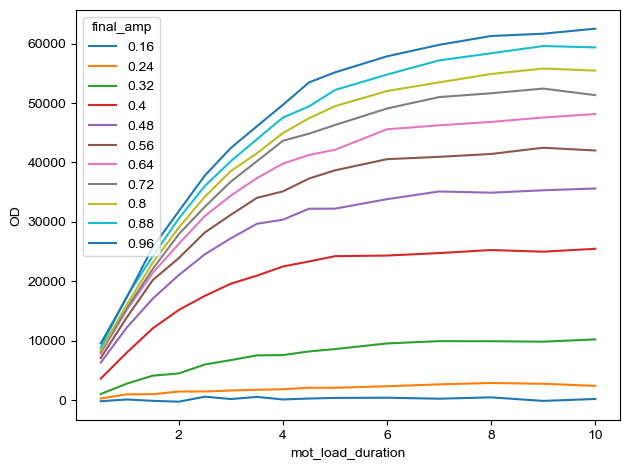

In [16]:
fig = plt.figure()
# ax = fig.gca()
Ncount_mean.plot.errorbar(hue='final_amp')
# plt.xlabel('MOT AOM Frequency (MHz)')
# plt.ylabel('MOT Gradient Coil Current (A)')
plt.tight_layout()
# plt.grid(visible=1)
plt.show()

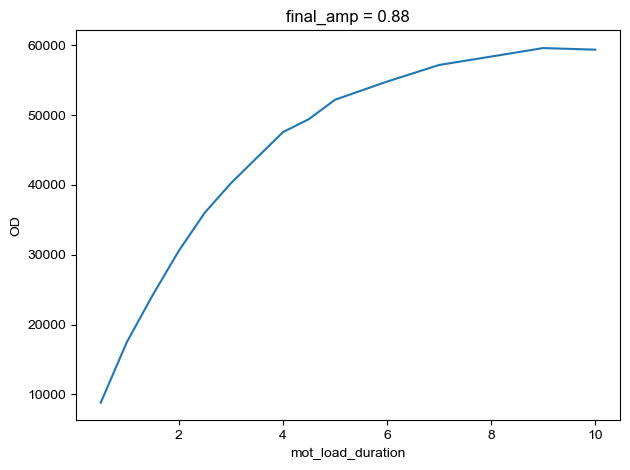

In [17]:
data = Ncount_mean.sel(final_amp=0.88)
data_std = Ncount_std.sel(final_amp=0.88)
fig = plt.figure()
# ax = fig.gca()
data.plot.errorbar()
# plt.xlabel('MOT AOM Frequency (MHz)')
# plt.ylabel('MOT Gradient Coil Current (A)')
plt.tight_layout()
# plt.grid(visible=1)
plt.show()

In [18]:
def factor_from_Ncounts_to_Natom():
    return 1 / (8.474337362524987e-14 * 0.3725) * 5.86e-6**2 / 0.438**2

In [19]:
def mot_loading(x, A, tau):
    return A * (1 - np.exp(-x / tau)) * np.heaviside(x, 0)

In [20]:
data = data * factor_from_Ncounts_to_Natom()
data_std = data_std * factor_from_Ncounts_to_Natom()

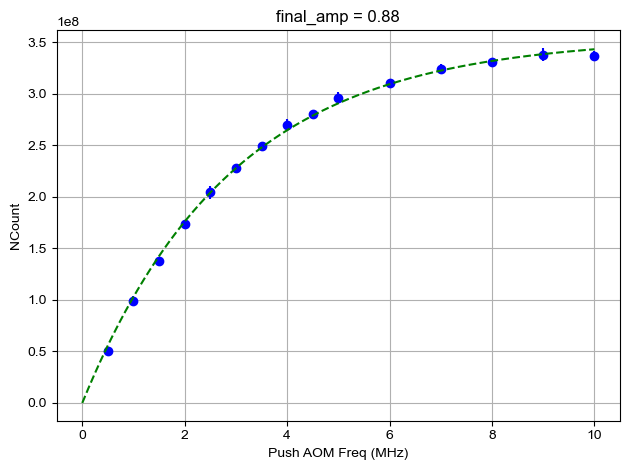

In [21]:
fitModel = NewFitModel(mot_loading)
fitAnalyser = FitAnalyser(fitModel, fitDim=1)

params = fitAnalyser.fitModel.make_params()
params.add(name="A", value=1e8, max=np.inf, min=-np.inf, vary=True)
params.add(name="tau", value=1, max=np.inf, min=-np.inf, vary=True)

fitResult = fitAnalyser.fit(data, params, x='mot_load_duration').load()
freqdata  = np.linspace(0, 10, 500)
fitCurve  = fitAnalyser.eval(fitResult, x=freqdata, dask="parallelized").load()
fitCurve  = fitCurve.assign_coords({'x':np.array(freqdata)})

fig = plt.figure()
ax = fig.gca()

data.plot.errorbar(ax=ax, yerr = data_std, fmt='ob')
fitCurve.plot.errorbar(ax=ax, fmt='--g')
plt.xlabel('Push AOM Freq (MHz)')
plt.ylabel('NCount')
plt.tight_layout()
plt.grid(visible=1)
plt.show()

In [22]:
val = fitAnalyser.get_fit_value(fitResult)
val

<xarray.Dataset>
Dimensions:    ()
Coordinates:
    final_amp  float64 0.88
Data variables:
    A          float64 3.548e+08
    tau        float64 2.918

In [23]:
std = fitAnalyser.get_fit_std(fitResult)
std

<xarray.Dataset>
Dimensions:    ()
Coordinates:
    final_amp  float64 0.88
Data variables:
    A          float64 2.776e+06
    tau        float64 0.05867

In [24]:
res = fitAnalyser.get_fit_full_result(fitResult)
res.A / res.tau / 1e8

<xarray.DataArray ()>
array(1.2157134383410748+/-0.02622973148346536, dtype=object)
Coordinates:
    final_amp  float64 0.88

## Without push

In [25]:
folderPath = img_dir + SequenceName + '2022/10/11'# get_date()

shotNum = "0018"
filePath = folderPath + "/" + shotNum + "/*.h5"

dataSetDict = {
    dskey[groupList[i]]: read_hdf5_file(filePath, groupList[i])
    for i in [0]
}

dataSet = dataSetDict["camera_0"]

print_scanAxis(dataSet)

scanAxis = get_scanAxis(dataSet)

dataSet = auto_rechunk(dataSet)

dataSet = imageAnalyser.get_absorption_images(dataSet)

imageAnalyser.center = (600, 1125)
imageAnalyser.span = (1100, 1200)
imageAnalyser.fraction = (0.1, 0.1)

dataSet_cropOD = imageAnalyser.crop_image(dataSet.OD)
dataSet_cropOD = imageAnalyser.substract_offset(dataSet_cropOD).load()

Ncount = imageAnalyser.get_Ncount(dataSet_cropOD)
Ncount_mean = calculate_mean(Ncount)
Ncount_std = calculate_std(Ncount)

The detected scaning axes and values are: 

{'mot_load_duration': array([ 0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,  5.5,
        6. ,  6.5,  7. ,  8. ,  9. , 10. , 11. , 12. , 13. , 14. , 15. ,
       16. ]), 'runs': array([0., 1.])}


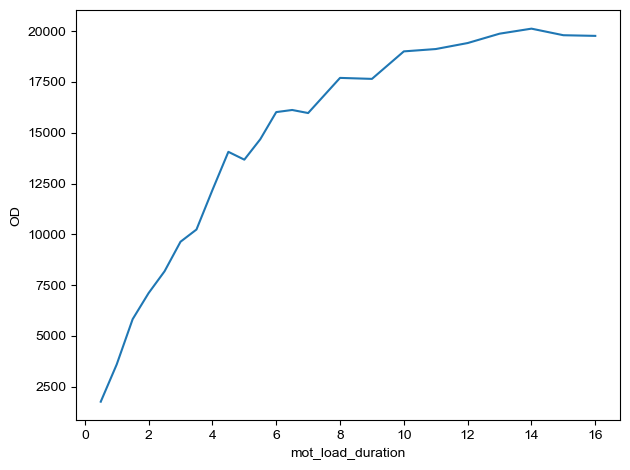

In [26]:
fig = plt.figure()
# ax = fig.gca()
Ncount_mean.plot.errorbar()
# plt.xlabel('MOT AOM Frequency (MHz)')
# plt.ylabel('MOT Gradient Coil Current (A)')
plt.tight_layout()
# plt.grid(visible=1)
plt.show()

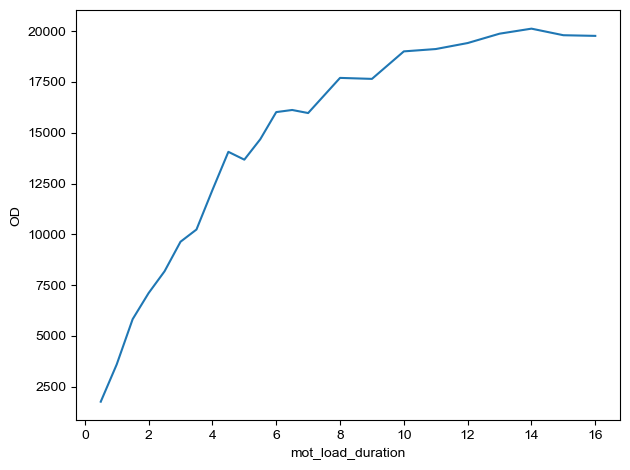

In [27]:
data = Ncount_mean
data_std = Ncount_std
fig = plt.figure()
# ax = fig.gca()
data.plot.errorbar()
# plt.xlabel('MOT AOM Frequency (MHz)')
# plt.ylabel('MOT Gradient Coil Current (A)')
plt.tight_layout()
# plt.grid(visible=1)
plt.show()

In [28]:
data = data * factor_from_Ncounts_to_Natom()
data_std = data_std * factor_from_Ncounts_to_Natom()

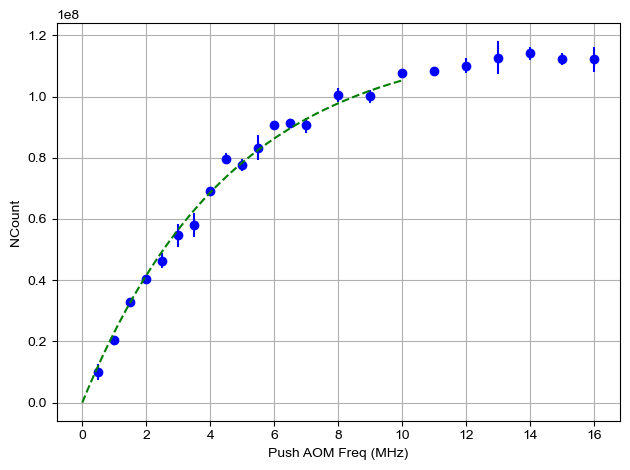

In [29]:
fitModel = NewFitModel(mot_loading)
fitAnalyser = FitAnalyser(fitModel, fitDim=1)

params = fitAnalyser.fitModel.make_params()
params.add(name="A", value=1e8, max=np.inf, min=-np.inf, vary=True)
params.add(name="tau", value=1, max=np.inf, min=-np.inf, vary=True)

fitResult = fitAnalyser.fit(data, params, x='mot_load_duration').load()
freqdata  = np.linspace(0, 10, 500)
fitCurve  = fitAnalyser.eval(fitResult, x=freqdata, dask="parallelized").load()
fitCurve  = fitCurve.assign_coords({'x':np.array(freqdata)})

fig = plt.figure()
ax = fig.gca()

data.plot.errorbar(ax=ax, yerr = data_std, fmt='ob')
fitCurve.plot.errorbar(ax=ax, fmt='--g')
plt.xlabel('Push AOM Freq (MHz)')
plt.ylabel('NCount')
plt.tight_layout()
plt.grid(visible=1)
plt.show()

In [30]:
val = fitAnalyser.get_fit_value(fitResult)
val

<xarray.Dataset>
Dimensions:  ()
Data variables:
    A        float64 1.193e+08
    tau      float64 4.666

In [31]:
std = fitAnalyser.get_fit_std(fitResult)
std

<xarray.Dataset>
Dimensions:  ()
Data variables:
    A        float64 1.591e+06
    tau      float64 0.1586

In [32]:
res = fitAnalyser.get_fit_full_result(fitResult)
res.A / res.tau / 1e8

<xarray.DataArray ()>
array(0.2556310933363963+/-0.009332131323758952, dtype=object)

# Loading rate

In [6]:
img_dir = '//DyLabNAS/Data/'
SequenceName = "Repetition_scan" + "/"

In [7]:
Ncount_to_atoms()

2492.803132748206

In [8]:
powers  = [150, 200, 250, 300, 350, 400]
ncounts_withpush = np.array([5072.7, 9171.8, 16721.7, 23160.8, 27965.0, 32395.8]) * Ncount_to_atoms()
ncount_withpush_errors = np.array([80.7, 146.9, 142.1, 514.9, 433.6, 631.2]) * Ncount_to_atoms()

ncounts_withoutpush = np.array([629.0, 1567.6, 3063.7, 4426.5, 4755.4, 4920.9]) * Ncount_to_atoms()
ncount_withoutpush_errors = np.array([22.9, 53.8, 79.9, 63.7, 191.5, 190.9]) * Ncount_to_atoms()

sat_ncount_withpush = np.array([23921.7, 39196.8, 60078.6, 75443.0, 84752.0, 91294.0]) * Ncount_to_atoms()
sat_ncount_withpush_errors = np.array([88.3, 138.8, 89.0, 278.0, 210.1, 355.1]) * Ncount_to_atoms()

sat_ncount_withoutpush = np.array([4224.1, 9672.3, 17949.6, 24080.9, 25218.2, 26968.5]) * Ncount_to_atoms()
sat_ncount_withoutpush_errors = np.array([37.5, 77.2, 105.9, 75.3, 217.6, 265.0]) * Ncount_to_atoms()

In [9]:
np.array([powers, ncounts_withpush, ncounts_withpush])

array([[1.50000000e+02, 2.00000000e+02, 2.50000000e+02, 3.00000000e+02,
        3.50000000e+02, 4.00000000e+02],
       [1.26452425e+07, 2.28634918e+07, 4.16839061e+07, 5.77353148e+07,
        6.97112396e+07, 8.07563517e+07],
       [1.26452425e+07, 2.28634918e+07, 4.16839061e+07, 5.77353148e+07,
        6.97112396e+07, 8.07563517e+07]])

In [37]:
np.savetxt('loading_rate_withpush.txt', 
           np.array([powers, ncounts_withpush, ncount_withpush_errors]),
        )

In [38]:
np.savetxt('loading_rate_withoutpush.txt', 
           np.array([powers, ncounts_withoutpush, ncount_withoutpush_errors]),
        )

In [39]:
np.savetxt('sat_ncount_withpush.txt', 
           np.array([powers, sat_ncount_withpush, sat_ncount_withpush_errors]),
        )

In [40]:
np.savetxt('sat_ncount_withoutpush.txt', 
           np.array([powers, sat_ncount_withoutpush, sat_ncount_withoutpush_errors]),
        )

In [41]:
np.savetxt('old_loading_rate_withpush.txt', 
           np.array([[430], [1.2157134383410748e8], [0.02622973148346536e8]]),
        )

In [42]:
np.savetxt('old_loading_rate_withoutpush.txt', 
           np.array([[430], [0.2556310933363963e8], [0.009332131323758952e8]]),
        )

In [43]:
np.savetxt('old_sat_ncount_withpush.txt', 
           np.array([[430], [3.54756438e8], [2776453.58029856]]),
        )

In [44]:
np.savetxt('old_sat_ncount_withoutpush.txt', 
           np.array([[430], [1.19289449e8], [1591103.66003124]]),
        )

In [ ]:
plot_axes.errorbar([430], [1.2157134383410748e8], yerr=[0.02622973148346536e8], color=plot_red, marker='^', **plot_kwarg)
plot_axes.errorbar([430], [0.2556310933363963e8], yerr=[0.009332131323758952e8], color='k', marker='*', markersize=15)

In [ ]:
plot_axes.errorbar([430], [3.54756438], yerr=[2776453.58029856/1e8], color=plot_red, marker='^', **plot_kwarg)
plot_axes.errorbar([430], [1.19289449], yerr=[1591103.66003124/1e8], color="k", marker='*', markersize=15)

## V1

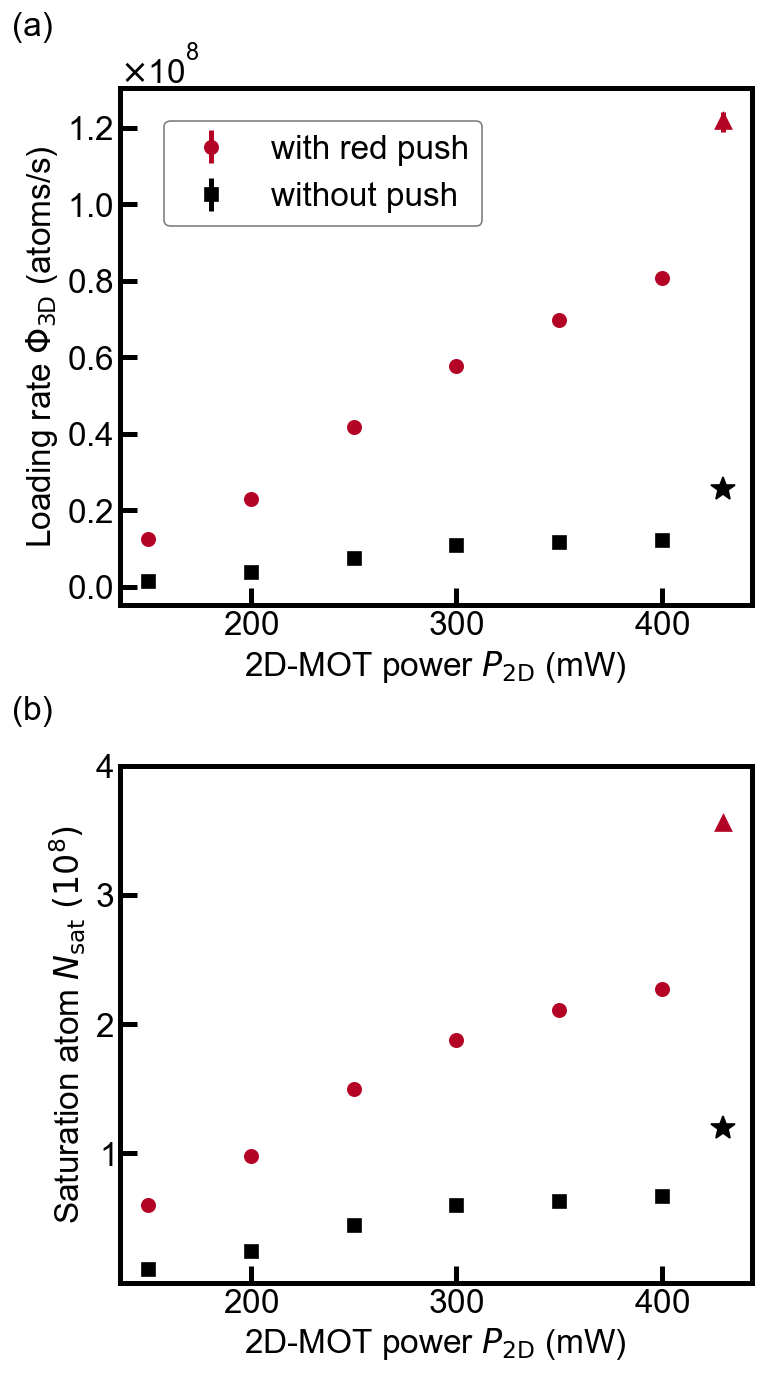

In [6]:
fig = plt.figure(figsize=(6.8, 6.8/4*3*2*(1 + 16/50)), dpi=120)
grid = fig.add_gridspec(4, 1, height_ratios=[2, 50, 10, 50], wspace=0.4, hspace=0.1)

######################
# fig.a
######################

plot_axes = plt.subplot(grid[1, 0])

plot_kwarg = {
    # 'fmt': 'o',
    
    # Style of line
    'linestyle': 'None',
    'linewidth': 2,
    
    # Style of markder
    # 'marker': '.',
    'markersize': 5,
    # 'markerfacecolor': plot_blue,
    # 'markeredgecolor': plot_blue,
    'markeredgewidth': 4,
    
    # Style of errorbar
    'capsize': 0,
    # 'ecolor': plot_blue, # color of errorbar line
    'capthick': 1.5,
    'elinewidth': 3,
    
    # text for legend
    'label': 'Experiment',
    }


# 1.2157134383410748+/-0.02622973148346536
# 0.2556310933363963+/-0.009332131323758952

plot_axes.errorbar(powers, ncounts_withpush, yerr=ncount_withpush_errors, color=plot_red, marker='o', **plot_kwarg)
plot_axes.errorbar(powers, ncounts_withoutpush, yerr=ncount_withoutpush_errors, color="k", marker='s', **plot_kwarg)
plot_axes.errorbar([430], [1.2157134383410748e8], yerr=[0.02622973148346536e8], color=plot_red, marker='^', **plot_kwarg)
plot_axes.errorbar([430], [0.2556310933363963e8], yerr=[0.009332131323758952e8], color='k', marker='*', markersize=15)

plot_axes.set_xlabel("2D-MOT power $P_\mathrm{2D}$ (mW)", fontsize=20)
plot_axes.set_ylabel("Loading rate $\Phi_\mathrm{3D}$ (atoms/s)", fontsize=20)

plot_axes.tick_params(axis='both', which='major', labelsize=20)
plot_axes.tick_params(axis='both', which='minor', labelsize=16)
plot_axes.xaxis.offsetText.set_fontsize(20)
plot_axes.yaxis.offsetText.set_fontsize(20)

plt.setp(plot_axes.spines.values(), linewidth=3)
plot_axes.xaxis.set_tick_params(width=3)
plot_axes.yaxis.set_tick_params(width=3)
plot_axes.tick_params(direction='in', length=10)

if np.max(plot_axes.get_xticks()) < 1000:
    plot_axes.ticklabel_format(scilimits=(0, 0), axis='x', style='plain', useMathText=True)
else:
    plot_axes.ticklabel_format(scilimits=(0, 0), axis='x', style='sci', useMathText=True)
if np.max(plot_axes.get_yticks()) < 1000:
    plot_axes.ticklabel_format(scilimits=(0, 0), axis='y', style='plain', useMathText=True)
else:
    plot_axes.ticklabel_format(scilimits=(0, 0), axis='y', style='sci', useMathText=True)

# plot_axes.set_ylim([-0.1e8, 9e7])

######################

plot_axes.legend( ["with red push", "without push"],
    fontsize=20, loc = 'lower right', bbox_to_anchor=(0.1, 0.7, 0.5, 0.5), shadow=False, 
    facecolor='white', framealpha=1, edgecolor='gray')

######################

######################
# fig.b
######################

plot_axes = plt.subplot(grid[3, 0])

plot_kwarg = {
    # 'fmt': 'o',
    
    # Style of line
    'linestyle': 'None',
    'linewidth': 2,
    
    # Style of markder
    # 'marker': '.',
    'markersize': 5,
    # 'markerfacecolor': plot_blue,
    # 'markeredgecolor': plot_blue,
    'markeredgewidth': 4,
    
    # Style of errorbar
    'capsize': 0,
    # 'ecolor': plot_blue, # color of errorbar line
    'capthick': 1.5,
    'elinewidth': 3,
    
    # text for legend
    # 'label': 'Experiment',
    }

plot_axes.errorbar([430], [3.54756438], yerr=[2776453.58029856/1e8], color=plot_red, marker='^', **plot_kwarg)
plot_axes.errorbar([430], [1.19289449], yerr=[1591103.66003124/1e8], color="k", marker='*', markersize=15)

plot_axes.errorbar(powers, sat_ncount_withpush / 1e8, yerr=sat_ncount_withpush_errors / 1e8, color=plot_red, marker='o', **plot_kwarg)
plot_axes.errorbar(powers, sat_ncount_withoutpush / 1e8, yerr=sat_ncount_withoutpush_errors / 1e8, color="k", marker='s', **plot_kwarg)

plot_axes.set_xlabel("2D-MOT power $P_\mathrm{2D}$ (mW)", fontsize=20)
plot_axes.set_ylabel("Saturation atom $N_\mathrm{sat}$ $(10^8)$", fontsize=20)

plot_axes.tick_params(axis='both', which='major', labelsize=20)
plot_axes.tick_params(axis='both', which='minor', labelsize=16)
plot_axes.xaxis.offsetText.set_fontsize(20)
plot_axes.yaxis.offsetText.set_fontsize(20)

plt.setp(plot_axes.spines.values(), linewidth=3)
plot_axes.xaxis.set_tick_params(width=3)
plot_axes.yaxis.set_tick_params(width=3)
plot_axes.tick_params(direction='in', length=10)

if np.max(plot_axes.get_xticks()) < 1000:
    plot_axes.ticklabel_format(scilimits=(0, 0), axis='x', style='plain', useMathText=True)
else:
    plot_axes.ticklabel_format(scilimits=(0, 0), axis='x', style='sci', useMathText=True)
if np.max(plot_axes.get_yticks()) < 1000:
    plot_axes.ticklabel_format(scilimits=(0, 0), axis='y', style='plain', useMathText=True)
else:
    plot_axes.ticklabel_format(scilimits=(0, 0), axis='y', style='sci', useMathText=True)

plot_axes.set_ylim([0, 4])

plt.setp(plot_axes.get_yticklabels()[0], visible=False)

######################################

plot_axes = plt.subplot(grid[0, 0])
plot_axes.text(-0.17, 0.8, '(a)', va='bottom', fontsize=20)
plot_axes.set_axis_off()

plot_axes = plt.subplot(grid[2, 0])
plot_axes.text(-0.17, 0.1, '(b)', va='bottom', fontsize=20)
plot_axes.set_axis_off()

fig.savefig('figS1_v2.pdf', bbox_inches = "tight")

plt.show()

## V2

In [30]:
def curve(A, P0, Psat, x):
    return A*(1-np.exp(-(x-P0)/Psat))

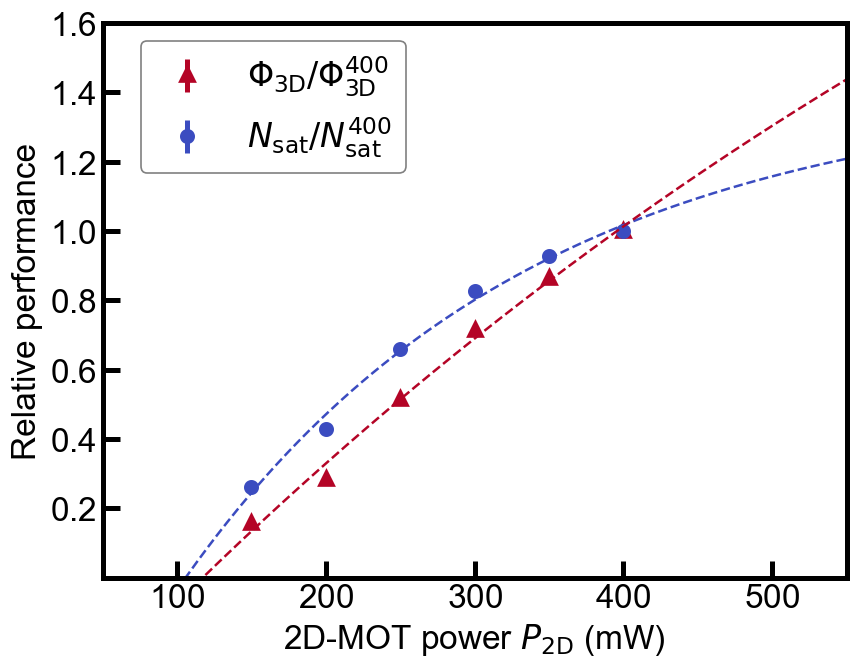

In [31]:
fig = plt.figure(figsize=(8, 6), dpi=120)

plot_axes = fig.gca()

plot_kwarg = {
    # 'fmt': 'o',
    
    # Style of line
    'linestyle': 'None',
    'linewidth': 2,
    
    # Style of markder
    # 'marker': '.',
    'markersize': 5,
    # 'markerfacecolor': plot_blue,
    # 'markeredgecolor': plot_blue,
    'markeredgewidth': 4,
    
    # Style of errorbar
    'capsize': 0,
    # 'ecolor': plot_blue, # color of errorbar line
    'capthick': 1.5,
    'elinewidth': 3,
    
    # text for legend
    'label': 'Experiment',
    }


# 1.2157134383410748+/-0.02622973148346536
# 0.2556310933363963+/-0.009332131323758952

Nmax = np.max(ncounts_withpush)
plot_axes.errorbar(powers, ncounts_withpush / Nmax, yerr=ncount_withpush_errors / Nmax, color=plot_red, marker='^', **plot_kwarg)

Nmax = np.max(sat_ncount_withpush)
plot_axes.errorbar(powers, sat_ncount_withpush / Nmax, yerr=sat_ncount_withpush_errors / Nmax, color=plot_blue, marker='o', **plot_kwarg)

x = np.linspace(100, 550, 1000)
fit_line = curve(1.422, 105.9, 234.2, x)
plot_axes.errorbar(x, fit_line, color=plot_blue, fmt='--')

x = np.linspace(100, 550, 1000)
fit_line = curve(3.843, 117.4, 923.4, x)
plot_axes.errorbar(x, fit_line, color=plot_red, fmt='--')

plot_axes.set_xlim([50, 550])
plot_axes.set_ylim([-0, 1.6])

plot_axes.set_xlabel("2D-MOT power $P_\mathrm{2D}$ (mW)", fontsize=20)
plot_axes.set_ylabel("Relative performance", fontsize=20)

plot_axes.tick_params(axis='both', which='major', labelsize=20)
plot_axes.tick_params(axis='both', which='minor', labelsize=16)
plot_axes.xaxis.offsetText.set_fontsize(20)
plot_axes.yaxis.offsetText.set_fontsize(20)

plt.setp(plot_axes.spines.values(), linewidth=3)
plot_axes.xaxis.set_tick_params(width=3)
plot_axes.yaxis.set_tick_params(width=3)
plot_axes.tick_params(direction='in', length=10)

if np.max(plot_axes.get_xticks()) < 1000:
    plot_axes.ticklabel_format(scilimits=(0, 0), axis='x', style='plain', useMathText=True)
else:
    plot_axes.ticklabel_format(scilimits=(0, 0), axis='x', style='sci', useMathText=True)
if np.max(plot_axes.get_yticks()) < 1000:
    plot_axes.ticklabel_format(scilimits=(0, 0), axis='y', style='plain', useMathText=True)
else:
    plot_axes.ticklabel_format(scilimits=(0, 0), axis='y', style='sci', useMathText=True)

plt.setp(plot_axes.get_xticklabels()[0], visible=False)
plt.setp(plot_axes.get_yticklabels()[0], visible=False)

plot_axes.legend( ["$\Phi_\mathrm{3D}/\Phi_\mathrm{3D}^{400}$", "$N_\mathrm{sat}/N_\mathrm{sat}^{400}$"],
    fontsize=20, loc = 'lower right', bbox_to_anchor=(-0.07, 0.7, 0.5, 0.5), shadow=False, 
    facecolor='white', framealpha=1, edgecolor='gray')

fig.savefig('figS1_v3.pdf', bbox_inches = "tight")

plt.show()

In [34]:
ncounts_withpush/1e7

array([1.26452425, 2.28634918, 4.16839061, 5.77353148, 6.97112396,
       8.07563517])

In [35]:
ncount_withpush_errors/1e7

array([0.02011692, 0.03661928, 0.03542273, 0.12835443, 0.10808794,
       0.15734573])

In [37]:
sat_ncount_withpush/1e8

array([0.59632089, 0.97709906, 1.49764122, 1.88064547, 2.11270051,
       2.27577969])

In [38]:
sat_ncount_withpush_errors/1e8

array([0.00220115, 0.00346001, 0.00221859, 0.00692999, 0.00523738,
       0.00885194])

## V3

In [10]:
def curve(A, P0, Psat, x):
    return A*(1-np.exp(-(x-P0)/Psat))

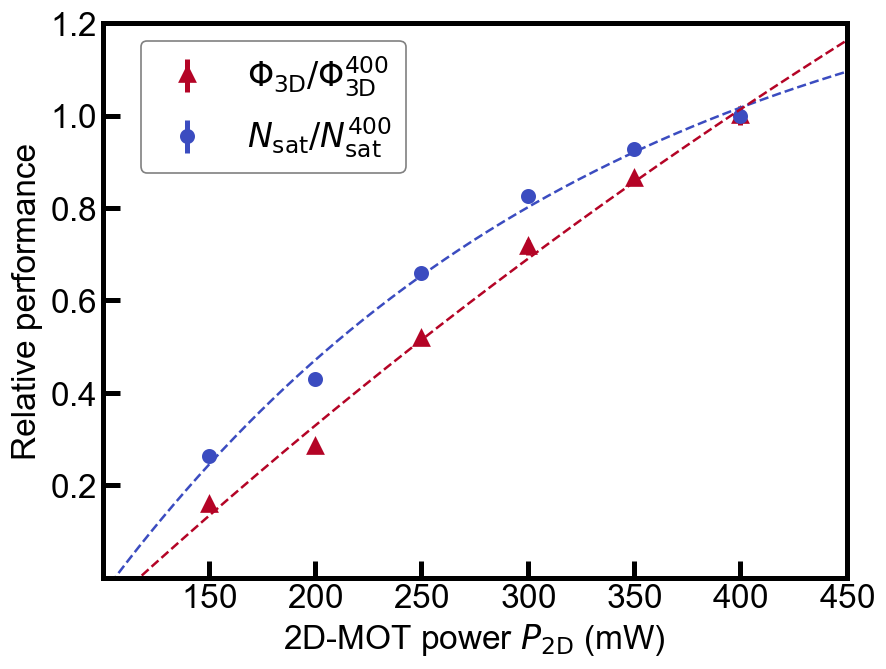

In [13]:
fig = plt.figure(figsize=(8, 6), dpi=120)

plot_axes = fig.gca()

plot_kwarg = {
    # 'fmt': 'o',
    
    # Style of line
    'linestyle': 'None',
    'linewidth': 2,
    
    # Style of markder
    # 'marker': '.',
    'markersize': 5,
    # 'markerfacecolor': plot_blue,
    # 'markeredgecolor': plot_blue,
    'markeredgewidth': 4,
    
    # Style of errorbar
    'capsize': 0,
    # 'ecolor': plot_blue, # color of errorbar line
    'capthick': 1.5,
    'elinewidth': 3,
    
    # text for legend
    'label': 'Experiment',
    }


# 1.2157134383410748+/-0.02622973148346536
# 0.2556310933363963+/-0.009332131323758952

Nmax = np.max(ncounts_withpush)
plot_axes.errorbar(powers, ncounts_withpush / Nmax, yerr=ncount_withpush_errors / Nmax, color=plot_red, marker='^', **plot_kwarg)

Nmax = np.max(sat_ncount_withpush)
plot_axes.errorbar(powers, sat_ncount_withpush / Nmax, yerr=sat_ncount_withpush_errors / Nmax, color=plot_blue, marker='o', **plot_kwarg)

x = np.linspace(100, 450, 1000)
fit_line = curve(1.422, 105.9, 234.2, x)
plot_axes.errorbar(x, fit_line, color=plot_blue, fmt='--')

x = np.linspace(100, 450, 1000)
fit_line = curve(3.843, 117.4, 923.4, x)
plot_axes.errorbar(x, fit_line, color=plot_red, fmt='--')

plot_axes.set_xlim([100, 450])
plot_axes.set_ylim([-0, 1.2])

plot_axes.set_xlabel("2D-MOT power $P_\mathrm{2D}$ (mW)", fontsize=20)
plot_axes.set_ylabel("Relative performance", fontsize=20)

plot_axes.tick_params(axis='both', which='major', labelsize=20)
plot_axes.tick_params(axis='both', which='minor', labelsize=16)
plot_axes.xaxis.offsetText.set_fontsize(20)
plot_axes.yaxis.offsetText.set_fontsize(20)

plt.setp(plot_axes.spines.values(), linewidth=3)
plot_axes.xaxis.set_tick_params(width=3)
plot_axes.yaxis.set_tick_params(width=3)
plot_axes.tick_params(direction='in', length=10)

if np.max(plot_axes.get_xticks()) < 1000:
    plot_axes.ticklabel_format(scilimits=(0, 0), axis='x', style='plain', useMathText=True)
else:
    plot_axes.ticklabel_format(scilimits=(0, 0), axis='x', style='sci', useMathText=True)
if np.max(plot_axes.get_yticks()) < 1000:
    plot_axes.ticklabel_format(scilimits=(0, 0), axis='y', style='plain', useMathText=True)
else:
    plot_axes.ticklabel_format(scilimits=(0, 0), axis='y', style='sci', useMathText=True)

plt.setp(plot_axes.get_xticklabels()[0], visible=False)
plt.setp(plot_axes.get_yticklabels()[0], visible=False)

plot_axes.legend( ["$\Phi_\mathrm{3D}/\Phi_\mathrm{3D}^{400}$", "$N_\mathrm{sat}/N_\mathrm{sat}^{400}$"],
    fontsize=20, loc = 'lower right', bbox_to_anchor=(-0.07, 0.7, 0.5, 0.5), shadow=False, 
    facecolor='white', framealpha=1, edgecolor='gray')

fig.savefig('figS1_v4.pdf', bbox_inches = "tight")

plt.show()